In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import massapp as mass
import regutil as reg


In [2]:
data = pd.read_spss('..\\SPSS\\data\\GISValTechSampleData.sav')
data.head()
data['ParcelId'] = data['ParcelId'].astype(int)
data['SaleDate'] = pd.to_datetime(data['SaleDate'])
data['SalesPrice'] = data['SalesPrice'].astype(int)
data['Sqft'] = data['Sqft'].astype(int)
data['LandSize'] = data['LandSize'].astype(int)
data['Quality'] = pd.Categorical(data['Quality'], ordered = True, categories = [
    'Poor', 'BelowAverage', 'Average', 'AboveAverage', 'Superior'])
data['GarageSize'] = data['GarageSize'].astype(int)
data['EffAge'] = data['EffAge'].astype(int)
data['NBHD'] = pd.Categorical(data['NBHD'].astype(int))

data.set_index('ParcelId', inplace = True)
data.head()

,SaleDate,SalesPrice,Sqft,LandSize,Bathrooms,Quality,GarageSize,EffAge,NBHD
ParcelId,,,,,,,,,
103525,2023-01-01,254596,1573,27325,2.5,BelowAverage,360,41,102
110784,2023-01-01,1151736,4586,14157,5.0,AboveAverage,484,18,105
116454,2023-01-01,501824,2548,17156,3.5,Average,384,10,103
138782,2023-01-02,789205,3312,34341,2.5,AboveAverage,360,16,104
102652,2023-01-03,548042,2455,34412,2.5,AboveAverage,484,55,104


In [3]:
data['SPPSF'] = data['SalesPrice'] / data['Sqft']
#data.groupby(['Quality'], observed = True)['SPPSF'].describe()
data.groupby(['Quality'], observed = True)['SPPSF'].aggregate(['count', 'mean', 'median', 'std' ])

,count,mean,median,std
Quality,,,,
Poor,64,122.984356,119.449408,28.164216
BelowAverage,247,146.912253,145.214533,30.349647
Average,271,185.376154,184.985541,31.991147
AboveAverage,180,241.806336,238.667971,35.123588
Superior,60,307.275931,299.384849,39.976580


In [4]:
data.groupby(['NBHD'], observed = True)['SPPSF'].aggregate(['count', 'mean', 'median', 'std' ])

,count,mean,median,std
NBHD,,,,
101,137,116.695077,114.362734,20.943218
102,215,166.801041,161.984105,30.758226
103,258,191.348178,187.546034,33.471539
104,124,239.150479,237.894661,37.336202
105,88,289.602511,289.527589,45.697791


In [5]:
data['SYEAR'] = data['SaleDate'].dt.year
data['SMONTH'] = data['SaleDate'].dt.month
data['SDATE'] = data['SaleDate'].dt.to_period('M').dt.to_timestamp()
pd.crosstab(data['SYEAR'], data['SMONTH'])

SMONTH,1,2,3,4,5,6,7,8,9,10,11,12
SYEAR,,,,,,,,,,,,
2023,118,33,40,53,87,82,76,71,70,61,82,49


In [6]:
startdate = pd.to_datetime('1/1/2023')
basedate = pd.to_datetime('12/31/2023')
timeperiod = (basedate.to_period('M') - startdate.to_period('M')).n
timeperiod

11

In [7]:
data['Months'] = [(x - startdate.to_period('M')).n for x in data['SaleDate'].dt.to_period('M')]
data['Month'] = timeperiod - data['Months']
data.head()


,SaleDate,SalesPrice,Sqft,LandSize,Bathrooms,Quality,GarageSize,EffAge,NBHD,SPPSF,SYEAR,SMONTH,SDATE,Months,Month
ParcelId,,,,,,,,,,,,,,,
103525,2023-01-01,254596,1573,27325,2.5,BelowAverage,360,41,102,161.853783,2023,1,2023-01-01,0,11
110784,2023-01-01,1151736,4586,14157,5.0,AboveAverage,484,18,105,251.141736,2023,1,2023-01-01,0,11
116454,2023-01-01,501824,2548,17156,3.5,Average,384,10,103,196.948195,2023,1,2023-01-01,0,11
138782,2023-01-02,789205,3312,34341,2.5,AboveAverage,360,16,104,238.286534,2023,1,2023-01-01,0,11
102652,2023-01-03,548042,2455,34412,2.5,AboveAverage,484,55,104,223.235031,2023,1,2023-01-01,0,11


In [8]:
def calculatePctGood(eff_age: int) -> float:
    if eff_age < 0:
        eff_age = 0
    elif eff_age > 60:
        eff_age = 60    
    return round(1 - (eff_age / 100), 2)
        
data['Pct_Good'] = data['EffAge'].apply(calculatePctGood)
data.head()
    

,SaleDate,SalesPrice,Sqft,LandSize,Bathrooms,Quality,GarageSize,EffAge,NBHD,SPPSF,SYEAR,SMONTH,SDATE,Months,Month,Pct_Good
ParcelId,,,,,,,,,,,,,,,,
103525,2023-01-01,254596,1573,27325,2.5,BelowAverage,360,41,102,161.853783,2023,1,2023-01-01,0,11,0.59
110784,2023-01-01,1151736,4586,14157,5.0,AboveAverage,484,18,105,251.141736,2023,1,2023-01-01,0,11,0.82
116454,2023-01-01,501824,2548,17156,3.5,Average,384,10,103,196.948195,2023,1,2023-01-01,0,11,0.90
138782,2023-01-02,789205,3312,34341,2.5,AboveAverage,360,16,104,238.286534,2023,1,2023-01-01,0,11,0.84
102652,2023-01-03,548042,2455,34412,2.5,AboveAverage,484,55,104,223.235031,2023,1,2023-01-01,0,11,0.45


In [9]:
model_data = pd.DataFrame({"LN_SalesPrice" : np.log(data['SalesPrice']), "const" : 1.00})
model_data = pd.concat([model_data, data['Months']], axis = 1 )
model_data = reg.add_continuous(model_data, data['Sqft'], 'LN_Sqft')
model_data = reg.add_continuous(model_data, data['LandSize'], 'LN_LandSize')
model_data = reg.add_binaries(model_data, data['Quality'], 'Quality_Average', 'Quality', min_sales = 6)
model_data = reg.add_continuous(model_data, data['Bathrooms'], 'LN_Bathrooms')
model_data = reg.add_continuous(model_data, data['Pct_Good'], 'LN_Pct_Good')
model_data = reg.add_continuous(model_data, data['GarageSize'], 'LN_GarageSize')
#modelData = reg.add_continuous(modelData, data['GarageSize'] / 480, 'LN_GarageSize_Ratio')
model_data = reg.add_binaries(model_data, data['NBHD'], 'NBHD_103', 'NBHD', min_sales = 6)
model_data

,LN_SalesPrice,const,Months,LN_Sqft,LN_LandSize,Quality_Poor,Quality_BelowAverage,Quality_AboveAverage,Quality_Superior,LN_Bathrooms,LN_Pct_Good,LN_GarageSize,NBHD_101,NBHD_102,NBHD_104,NBHD_105
ParcelId,,,,,,,,,,,,,,,,
103525,12.447433,1.0,0,7.360740,10.215557,0.0,1.0,0.0,0.0,0.916291,-0.527633,5.888878,0.0,1.0,0.0,0.0
110784,13.956781,1.0,0,8.430763,9.557964,0.0,0.0,1.0,0.0,1.609438,-0.198451,6.184149,0.0,0.0,0.0,1.0
116454,13.126005,1.0,0,7.843064,9.750103,0.0,0.0,0.0,0.0,1.252763,-0.105361,5.953243,0.0,0.0,0.0,0.0
138782,13.578781,1.0,0,8.105308,10.444095,0.0,0.0,1.0,0.0,0.916291,-0.174353,5.888878,0.0,0.0,1.0,0.0
102652,13.214107,1.0,0,7.805882,10.446161,0.0,0.0,1.0,0.0,0.916291,-0.798508,6.184149,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111457,12.194294,1.0,11,7.362645,9.912844,1.0,0.0,0.0,0.0,0.916291,-0.867501,5.888878,0.0,1.0,0.0,0.0
109969,12.682953,1.0,11,7.308543,10.005006,0.0,1.0,0.0,0.0,1.098612,-0.342490,5.579730,0.0,1.0,0.0,0.0
113733,11.884137,1.0,11,7.045777,9.629906,0.0,1.0,0.0,0.0,0.693147,-0.916291,0.000000,1.0,0.0,0.0,0.0


In [10]:
# This assumes dependent variable is in the first column
while True:
    model = sm.OLS(
        model_data.iloc[:, 0],
        model_data.drop(model_data.columns[0], axis = 1)
    ).fit()
    ix = model.pvalues[model.pvalues.index != 'const'].idxmax()
    if(model.pvalues[ix] <= .05):
        break
    else:
        print("Dropping {0} p-value: {1} ".format(str(ix), model.pvalues[ix].round(3)))
        model_data.drop(columns = ix, inplace = True)

model.summary()

Dropping NBHD_102 p-value: 0.224 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          LN_SalesPrice   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1772.
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:28:32   Log-Likelihood:                 543.87
No. Observations:                 822   AIC:                            -1060.
Df Residuals:                     808   BIC:                            -993.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.9914      0.263     18.952      0.000       4.474       5.508
Months                   0.0103      0.001      7.995      0.000       0.008       0.013
LN_Sqft                  0.9344      0.021     43.806      0.000       0.892       0.976
LN_LandSize              0.0696      0.018      3.763      0.000       0.033       0.106
Quality_Poor            -0.2559      0.020    -12.545      0.000      -0.296      -0.216
Quality_BelowAverage    -0.1612      0.013    -12.121      0.000      -0.187      -0.135
Quality_AboveAverage     0.1728      0.014     12.247      0.000       0.145       0.200
Quality_Superior         0.3523      0.024     14.866      0.000       0.306       0.399
LN_Bathrooms             0.0710      0.026      2.784      0.006       0.021       0.121
LN_Pct_Good              0.2525      0.019     13.145      0.000       0.215       0.290
LN_GarageSize            0.0072      0.002      3.363      0.001       0.003       0.011
NBHD_101                -0.2235      0.019    -11.758      0.000      -0.261      -0.186
NBHD_104                 0.0681      0.020      3.368      0.001       0.028       0.108
NBHD_105                 0.1129      0.029      3.939      0.000       0.057       0.169
==============================================================================
Omnibus:                       22.223   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.407
Skew:                          -0.389   Prob(JB):                     8.27e-06
Kurtosis:                       3.281   Cond. No.                         867.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
model.params

const                   4.991421
Months                  0.010282
LN_Sqft                 0.934356
LN_LandSize             0.069569
Quality_Poor           -0.255861
Quality_BelowAverage   -0.161182
Quality_AboveAverage    0.172783
Quality_Superior        0.352297
LN_Bathrooms            0.071049
LN_Pct_Good             0.252519
LN_GarageSize           0.007184
NBHD_101               -0.223483
NBHD_104                0.068102
NBHD_105                0.112873
dtype: float64

In [12]:
# In statsmodels, "BSE" stands for "Standard Error of the coefficient"; 
# it represents the estimated standard deviation of a regression coefficient, indicating how much 
# the coefficient is likely to vary if the analysis was repeated with a different sample 
# from the population. 
model.bse

const                   0.263372
Months                  0.001286
LN_Sqft                 0.021329
LN_LandSize             0.018490
Quality_Poor            0.020396
Quality_BelowAverage    0.013297
Quality_AboveAverage    0.014108
Quality_Superior        0.023699
LN_Bathrooms            0.025525
LN_Pct_Good             0.019210
LN_GarageSize           0.002136
NBHD_101                0.019007
NBHD_104                0.020220
NBHD_105                0.028658
dtype: float64

In [13]:
reg.get_parameter_coverage(model_data)

LN_SalesPrice           822
const                   822
Months                  704
LN_Sqft                 822
LN_LandSize             822
Quality_Poor             64
Quality_BelowAverage    247
Quality_AboveAverage    180
Quality_Superior         60
LN_Bathrooms            822
LN_Pct_Good             812
LN_GarageSize           601
NBHD_101                137
NBHD_104                124
NBHD_105                 88
Name: Coefficient Coverage, dtype: int64

In [14]:
data['ESP'] = reg.estimate_parcel_value(model_data, model.params ).astype(int)
data['Ratio'] = round((data['ESP'] / data['SalesPrice']), 2)
data.head()

,SaleDate,SalesPrice,Sqft,LandSize,Bathrooms,Quality,GarageSize,EffAge,NBHD,SPPSF,SYEAR,SMONTH,SDATE,Months,Month,Pct_Good,ESP,Ratio
ParcelId,,,,,,,,,,,,,,,,,,
103525,2023-01-01,254596,1573,27325,2.5,BelowAverage,360,41,102,161.853783,2023,1,2023-01-01,0,11,0.59,241023,0.95
110784,2023-01-01,1151736,4586,14157,5.0,AboveAverage,484,18,105,251.141736,2023,1,2023-01-01,0,11,0.82,1119078,0.97
116454,2023-01-01,501824,2548,17156,3.5,Average,384,10,103,196.948195,2023,1,2023-01-01,0,11,0.90,490466,0.98
138782,2023-01-02,789205,3312,34341,2.5,AboveAverage,360,16,104,238.286534,2023,1,2023-01-01,0,11,0.84,802523,1.02
102652,2023-01-03,548042,2455,34412,2.5,AboveAverage,484,55,104,223.235031,2023,1,2023-01-01,0,11,0.45,519385,0.95


{'PRB': -0.02525134497637703, 'sig': 3.990936401300873e-08}

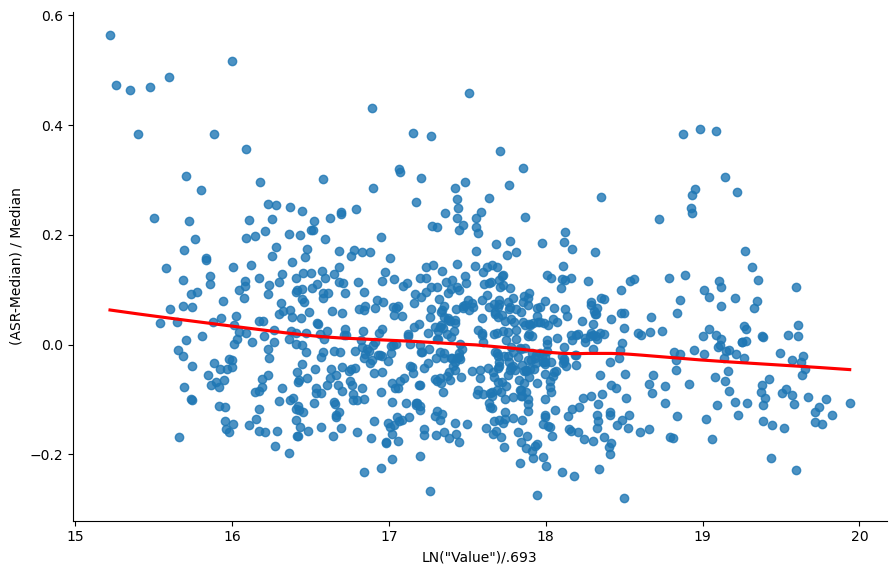

In [15]:
#PRB is centered around 0 and has a generally accepted value of between -0.05 and 0.05 and statically significant
#As defined in the IAAO Standard on Ratio Studies Section 9.2.7. 
#Higher PRB values indicate progressivity in assessment, while negative values indicate regressivity.
#The default significance level is 0.05
mass.PRB(data['ESP'], data['SalesPrice'], show_graph = True)

In [16]:
mass.ratio_statistics(data, 'NBHD', 'ESP', 'SalesPrice')

,Count,Mean,Median,WgtMean,Min,Max,PRD,COD,PRB,sig
NBHD,,,,,,,,,,
101,137,1.011,0.988,0.989,0.730751,1.559355,1.022,12.049,-0.256,0.000
102,215,1.012,0.997,0.997,0.772472,1.511113,1.015,9.874,-0.183,0.000
103,258,1.004,0.992,0.990,0.718479,1.426567,1.014,9.489,-0.205,0.000
104,124,1.007,1.014,0.996,0.769860,1.453177,1.011,9.026,-0.102,0.000
105,88,1.008,0.986,0.994,0.769017,1.388832,1.014,10.022,-0.271,0.000


In [ ]:
mass.ratio_statistics(data, 'SDATE', 'ESP', 'SalesPrice')

,Count,Mean,Median,WgtMean,Min,Max,PRD,COD,PRB,sig
SDATE,,,,,,,,,,
2023-01-01,118,0.985,0.964,0.968,0.723263,1.511113,1.017,10.668,-0.030,0.025
2023-02-01,33,1.063,1.059,1.005,0.769017,1.458560,1.058,10.591,-0.057,0.007
2023-03-01,40,1.020,1.013,0.996,0.772472,1.482781,1.024,10.336,-0.043,0.032
2023-04-01,53,1.003,0.985,0.987,0.794836,1.285866,1.015,9.004,-0.019,0.278
2023-05-01,87,1.024,1.015,1.017,0.718479,1.384639,1.006,10.295,-0.014,0.335
2023-06-01,82,1.020,1.013,1.017,0.831283,1.279640,1.002,7.705,-0.004,0.712
2023-07-01,76,0.999,0.977,0.990,0.769860,1.559355,1.010,9.819,-0.035,0.046
2023-08-01,71,1.006,1.016,0.999,0.730751,1.388832,1.007,10.026,-0.017,0.293
2023-09-01,70,0.996,0.996,0.975,0.758050,1.351161,1.022,9.084,-0.016,0.222


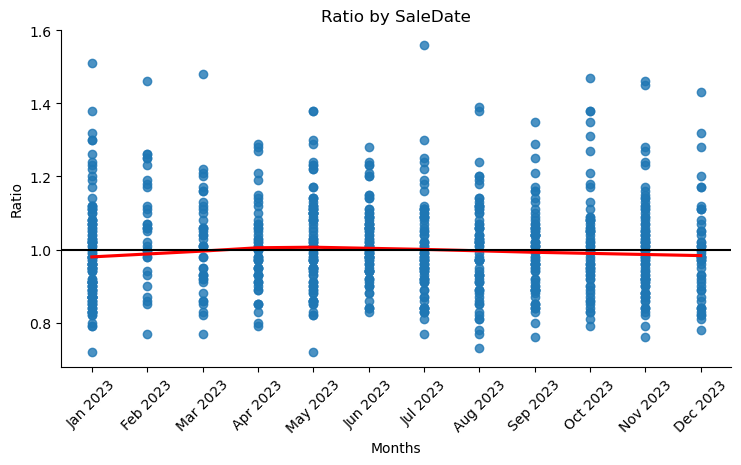

In [19]:
p = sns.lmplot(x='Months', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.figure.set_figwidth(8)
p.figure.set_figheight(4)
p.ax.set_title("Ratio by SaleDate")
p.ax.ticklabel_format(useOffset=False)
label = [x.strftime('%b %Y') for x in data.sort_values(by='SaleDate')["SDATE"].unique()]
p.ax.set_xticks(range(len(label)), labels=label)
p.ax.tick_params(axis="x", labelrotation=45)
plt.axhline(y=1.00, color = 'black')

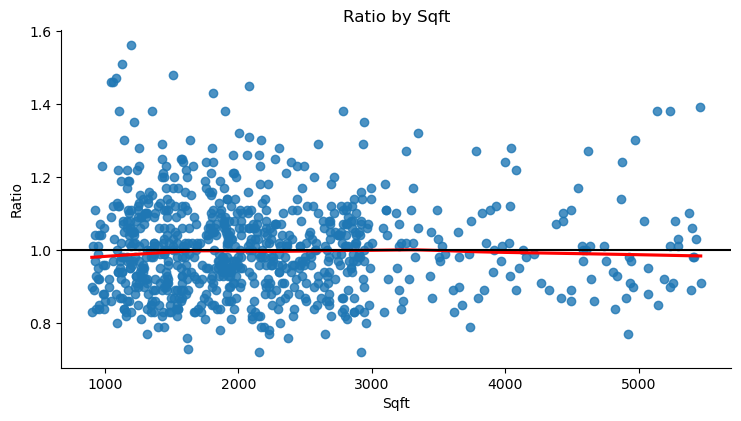

In [20]:
p = sns.lmplot(x='Sqft', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.figure.set_figwidth(8)
p.figure.set_figheight(4)
p.ax.set_title("Ratio by Sqft")
p.ax.ticklabel_format(useOffset=False)
plt.axhline(y=1.00, color = 'black')

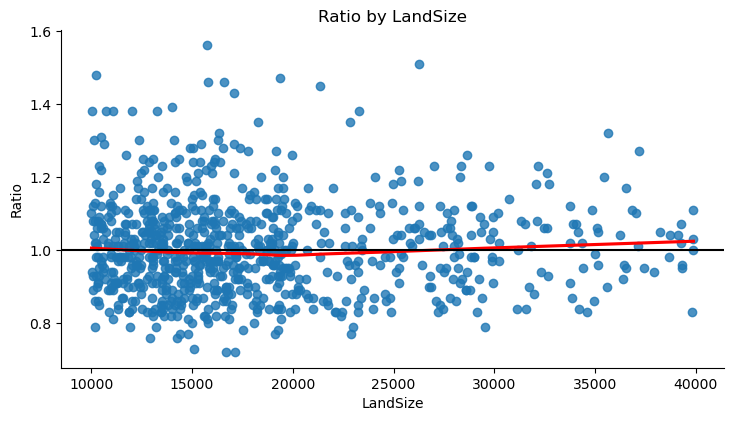

In [21]:
p = sns.lmplot(x='LandSize', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.figure.set_figwidth(8)
p.figure.set_figheight(4)
p.ax.set_title("Ratio by LandSize")
p.ax.ticklabel_format(useOffset=False)
plt.axhline(y=1.00, color = 'black')

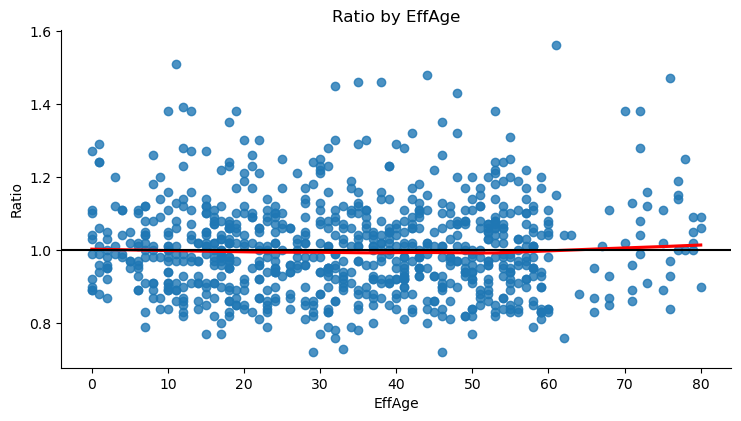

In [22]:
p = sns.lmplot(x='EffAge', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.figure.set_figwidth(8)
p.figure.set_figheight(4)
p.ax.set_title("Ratio by EffAge")
p.ax.ticklabel_format(useOffset=False)
plt.axhline(y=1.00, color = 'black')

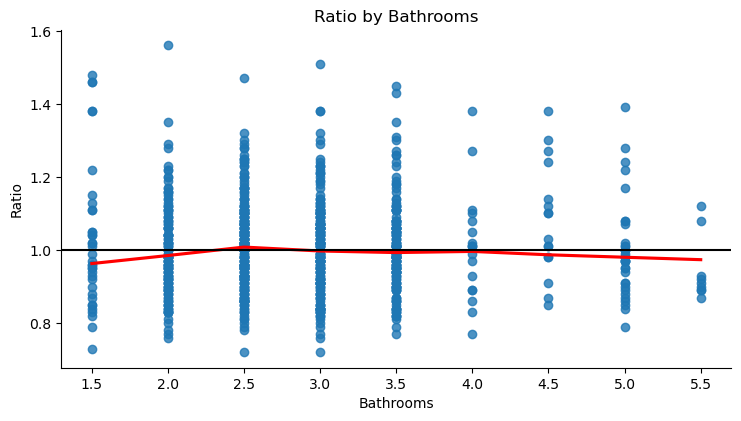

In [23]:
p = sns.lmplot(x='Bathrooms', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.figure.set_figwidth(8)
p.figure.set_figheight(4)
p.ax.set_title("Ratio by Bathrooms")
p.ax.ticklabel_format(useOffset=False)
plt.axhline(y=1.00, color = 'black')

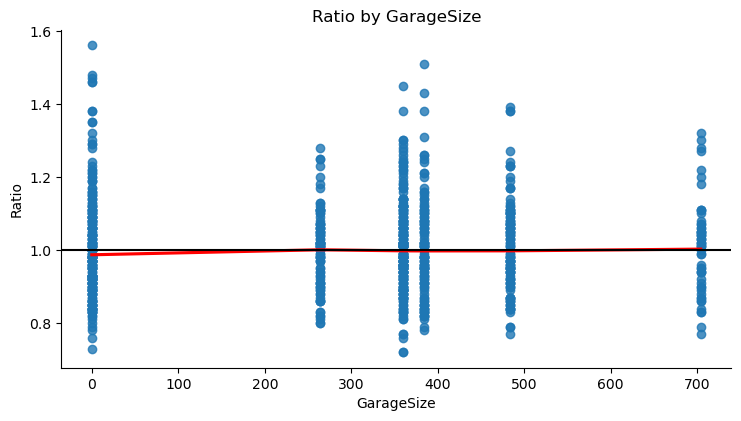

In [24]:
p = sns.lmplot(x='GarageSize', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.figure.set_figwidth(8)
p.figure.set_figheight(4)
p.ax.set_title("Ratio by GarageSize")
p.ax.ticklabel_format(useOffset=False)
plt.axhline(y=1.00, color = 'black')

In [25]:
data.groupby('Quality', observed=True)['Ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
Quality,,,,,,,,
Poor,64.0,1.010156,0.154760,0.77,0.9200,0.985,1.09,1.56
BelowAverage,247.0,1.008138,0.130726,0.76,0.9100,1.000,1.09,1.51
Average,271.0,1.008376,0.131691,0.72,0.9200,0.990,1.08,1.43
AboveAverage,180.0,1.006611,0.117683,0.77,0.9200,1.000,1.07,1.45
Superior,60.0,1.006500,0.125223,0.79,0.9075,0.995,1.06,1.38


In [26]:
data.groupby(['Quality'], observed = True)['Ratio'].aggregate(['count', 'mean', 'median', 'min', 'max' ])

,count,mean,median,min,max
Quality,,,,,
Poor,64,1.010156,0.985,0.77,1.56
BelowAverage,247,1.008138,1.000,0.76,1.51
Average,271,1.008376,0.990,0.72,1.43
AboveAverage,180,1.006611,1.000,0.77,1.45
Superior,60,1.006500,0.995,0.79,1.38


In [27]:
data.loc[(data['Ratio'] >= 1.5) | (data['Ratio'] <= .75), ]

,SaleDate,SalesPrice,Sqft,LandSize,Bathrooms,Quality,GarageSize,EffAge,NBHD,SPPSF,SYEAR,SMONTH,SDATE,Months,Month,Pct_Good,ESP,Ratio
ParcelId,,,,,,,,,,,,,,,,,,
119180,2023-01-13,130975,1127,26275,3.0,BelowAverage,384,11,102,116.215617,2023,1,2023-01-01,0,11,0.89,197918,1.51
101794,2023-01-27,504089,2156,17134,3.0,Average,360,46,103,233.807514,2023,1,2023-01-01,0,11,0.54,364589,0.72
108121,2023-05-14,740719,2918,16688,2.5,Average,360,29,103,253.844757,2023,5,2023-05-01,4,7,0.71,532191,0.72
105323,2023-07-31,76438,1200,15718,2.0,Poor,0,61,101,63.698333,2023,7,2023-07-01,6,5,0.40,119194,1.56
103662,2023-08-26,314445,1625,15084,1.5,Average,0,33,101,193.504615,2023,8,2023-08-01,7,4,0.67,229781,0.73


In [28]:
data.loc[(data['Ratio'] >= 1.5) | (data['Ratio'] <= .75), ].to_excel('.\\reports\\multiplicativebadratio.xlsx')